In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import selectivesearch

In [2]:
X = tf.placeholder(tf.float32, shape=[None, 64*64*3],name="input")
t = tf.placeholder(tf.float32, shape=[None, 2])

### 入力層
input_layer = tf.reshape(X, [-1,64,64,3])

### 畳込み層、プーリング層1
h_conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding='same',activation=tf.nn.relu)
h_pool1 = tf.layers.max_pooling2d(inputs=h_conv1,pool_size=(2,2),strides=(2,2),padding='same')

### 畳込み層、プーリング層2
h_conv2 = tf.layers.conv2d(inputs=h_pool1,filters=64,kernel_size=[5, 5],padding='same',activation=tf.nn.relu)
h_pool2 = tf.layers.max_pooling2d(inputs=h_conv2,pool_size=(2,2),strides=(2,2),padding='same')
### 全結合層
stddev = np.sqrt(2.0 / 16*16*64)
h_W_fc1 = tf.Variable(tf.truncated_normal([16*16*64,256], stddev=stddev))
h_b_fc1 = tf.Variable(tf.constant(0.1, shape=[256]))
h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, h_W_fc1) + h_b_fc1)

### ドロップアウト
keep_prob = tf.placeholder(tf.float32) # ドロップアウトする割合
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### 出力層
stddev = np.sqrt(2.0 / 256)
W_fc2 = tf.Variable(tf.truncated_normal([256,2], stddev=stddev))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[2]))
fc = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
y_conv = tf.nn.softmax(fc,name="output")

### 損失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y_conv))

### 学習op
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)

### モデルの評価
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(t,1))
# 精度
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [3]:
def get_RegionProposal(img):
  # SelectiveSearchで候補領域を得る
  out_img = img.copy()
  img_lbl, regions = selectivesearch.selective_search(np.array(img), scale=200, sigma=0.9, min_size=10)

  trim_images=[]
  Region_Size = []
  candidates = set()
  for r in regions:
      # excluding same rectangle (with different segments)
      if r['rect'] in candidates:
          continue
      # excluding regions smaller than 2000 pixels
      if r['size'] < 2000:
          continue
      # distorted rects
      x, y, w, h = r['rect']
      if w / h > 1.2 or h / w > 1.2:
          continue
      candidates.add(r['rect'])

  # draw rectangles on the original image
  for x, y, w, h in candidates:
      R = np.random.randint(0,255)
      G = np.random.randint(0,255)
      B = np.random.randint(0,255)
      print x, y, w, h
      Region_Size.append([x,y,w,h])
      cv2.rectangle(out_img, (x, y), (x+w, y+h), (B, G, R), 2)
      tmp = img[y:y+h,x:x+w]
      resize_img = cv2.resize(tmp, (64,64))
      trim_images.append(resize_img)

  return trim_images,out_img,Region_Size

In [4]:
def predict_fromRegionProposal(images):
  # 候補領域から画像認識を行う
  max_prob = 0
  best_ans = None
  i = 0
  idx = 0
  for img in images:
    ans = sess.run(fc,feed_dict={X:np.array(img).reshape(-1,64*64*3),keep_prob:1.0})
    p = np.argmax(ans,axis=1)
    if(max_prob < ans[:,p]):
      max_prob = ans[:,p]
      best_ans = ans
      idx = i
      print("Num " + str(i) + " : " + str(max_prob))
    i += 1

  return best_ans,idx

In [5]:
img_path = "./RCNN_predict_images/testimage1.jpg"
img = cv2.imread(img_path)
trim_images,out_img,Region_size = get_RegionProposal(img)

65 0 114 132
0 52 199 247
55 0 144 132
30 0 132 115
30 0 133 115
147 0 52 101
55 0 124 132
84 0 89 45
63 19 89 84
0 217 45 82
147 0 52 100
55 0 144 133
0 0 199 299
63 19 89 85
69 0 104 103
95 98 104 200
69 0 110 103
30 0 122 104
84 0 89 103


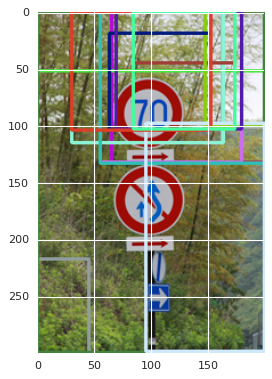

In [6]:
plt.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))

In [7]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('./RoadSign-ckpt')
if ckpt:
  # checkpointファイルから最後に保存したモデルへのパスを取得する
  last_model = ckpt.model_checkpoint_path
  print("load {0}".format(last_model))
  # 学習済みモデルを読み込む
  saver.restore(sess, last_model)

load ./RoadSign-ckpt/roadsign-conv
INFO:tensorflow:Restoring parameters from ./RoadSign-ckpt/roadsign-conv


In [8]:
best_ans,idx = predict_fromRegionProposal(trim_images)

Num 0 : [[ 32022.57421875]]
Num 3 : [[ 36293.9375]]
Num 4 : [[ 36403.49609375]]
Num 14 : [[ 45667.05078125]]


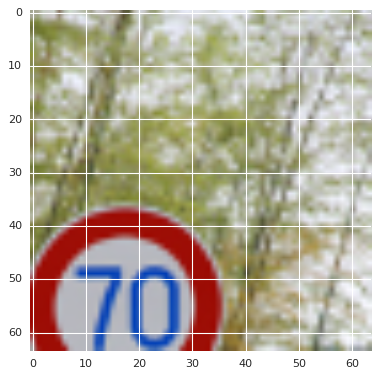

In [9]:
plt.imshow(cv2.cvtColor(trim_images[idx],cv2.COLOR_BGR2RGB))

(69, 0, 104, 103)
[[     0.          45667.05078125]]
RoadSign is LimitSpeed


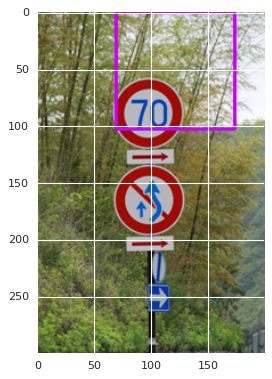

In [10]:
x,y,w,h = np.array(Region_size[idx])
print(x,y,w,h)
show_img = cv2.imread(img_path)
cv2.rectangle(show_img, (x, y), (x+w,y+h), (255, 0, 200), 2)
plt.imshow(cv2.cvtColor(show_img,cv2.COLOR_BGR2RGB))

idx_label = np.argmax(best_ans)
print(best_ans)
if(idx_label == 0):
  print("RoadSign is Stop")
elif(idx_label == 1):
  print("RoadSign is LimitSpeed")

In [11]:
img_path = "./RCNN_predict_images/testimage2.jpg"
img = cv2.imread(img_path)
trim_images,out_img,Region_size = get_RegionProposal(img)

142 334 182 145
0 263 309 216
0 266 304 213
227 34 182 252
0 31 317 175
326 91 313 179
350 91 289 179
142 334 180 145
326 306 313 164
0 34 443 445
227 34 182 189
0 34 409 445
235 44 164 144
327 155 214 114
0 34 420 445
265 89 102 99
326 301 313 169
0 0 639 479
227 34 182 253
327 91 312 179
0 34 639 445


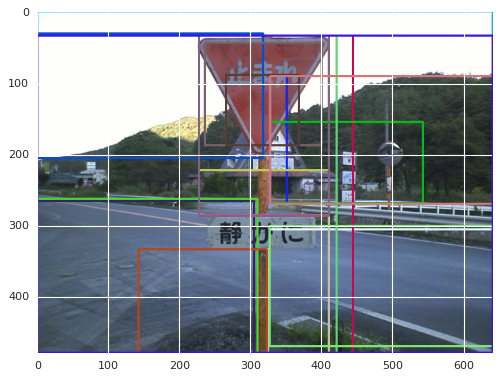

In [12]:
plt.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))

Num 0 : [[ 15729.25683594]]
Num 4 : [[ 19919.01953125]]
Num 10 : [[ 22041.43945312]]


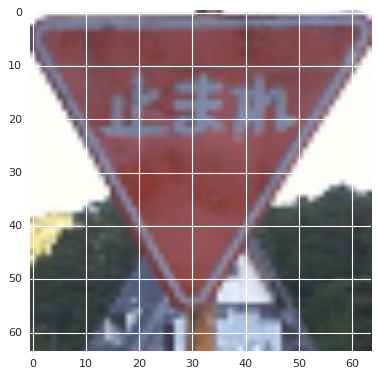

In [13]:
best_ans,idx = predict_fromRegionProposal(trim_images)
plt.imshow(cv2.cvtColor(trim_images[idx],cv2.COLOR_BGR2RGB))

(227, 34, 182, 189)
RoadSign is Stop


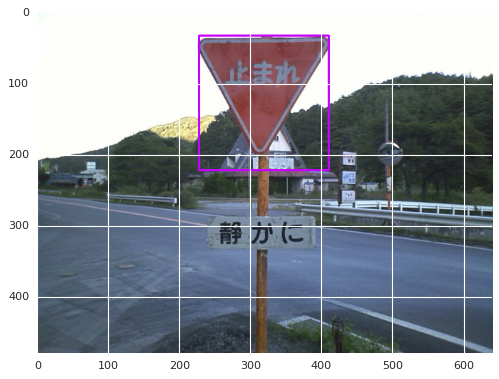

In [14]:
x,y,w,h = np.array(Region_size[idx])
print(x,y,w,h)
show_img = cv2.imread(img_path)
cv2.rectangle(show_img, (x, y), (x+w,y+h), (255, 0, 200), 2)
plt.imshow(cv2.cvtColor(show_img,cv2.COLOR_BGR2RGB))

idx_label = np.argmax(best_ans)
if(idx_label == 0):
  print("RoadSign is Stop")
elif(idx_label == 1):
  print("RoadSign is LimitSpeed")